In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up matplotlib style 
plt.style.use('ggplot')

# Libraries for wordcloud making and image importing
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# And libraries for data transformation
import datetime
from string import punctuation

#words counter
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.tokenize import word_tokenize 

#model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from itertools import compress
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap


In [2]:
#import data
data = pd.read_csv('../output/google_homemini450.csv')
data.info()
# Data overlook
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            4500 non-null   float64
 1   date              4500 non-null   object 
 2   shop              4500 non-null   object 
 3   title             4500 non-null   object 
 4   verified_reviews  4499 non-null   object 
dtypes: float64(1), object(4)
memory usage: 175.9+ KB


,rating,date,shop,title,verified_reviews
0,5.0,3 months ago,lowes.com,"Great way to get started with a ""smart home""","Not only has this been fun to use, it's making..."
1,5.0,3 months ago,lowes.com,Functional small speaker with big sound,The “Smart Light Starter Kit” consists of 2 pr...
2,5.0,8 months ago,Best Buy,Solid Combo Makes a Good Smart Home Starting P...,If you're invested in the Google ecosystem and...
3,1.0,2 months ago,lowes.com,I don't know what went wrong??? Bulb doesn't work,I bought the kit on Black Friday 2019 for $20 ...
4,4.0,4 months ago,lowes.com,Nice if you don't mind privacy issues,"First off, let's be clear. The kit includes a ..."


In [3]:
# Transform string data and remove punctuation
data['verified_reviews'] = data.verified_reviews.apply(lambda x: str(x).lower())
data['verified_reviews'] = data.verified_reviews.apply(lambda x: ''.join([c for c in x if c not in punctuation]))

In [4]:
# Get length of review for EDA
data['review_length'] = data.verified_reviews.apply(lambda x: len(x))

In [5]:
# Check the data again
data.head()

,rating,date,shop,title,verified_reviews,review_length
0,5.0,3 months ago,lowes.com,"Great way to get started with a ""smart home""",not only has this been fun to use its making m...,2672
1,5.0,3 months ago,lowes.com,Functional small speaker with big sound,the “smart light starter kit” consists of 2 pr...,4423
2,5.0,8 months ago,Best Buy,Solid Combo Makes a Good Smart Home Starting P...,if youre invested in the google ecosystem and ...,2487
3,1.0,2 months ago,lowes.com,I don't know what went wrong??? Bulb doesn't work,i bought the kit on black friday 2019 for 20 b...,2248
4,4.0,4 months ago,lowes.com,Nice if you don't mind privacy issues,first off lets be clear the kit includes a sma...,2413


In [6]:
# Take a look at the mean, standard deviation, and maximum
print('The mean for the length of review:',data['review_length'].mean())
print('The standard deviation for the length of reviews:',data['review_length'].std())
print('The maximum for the length of reviews:',data['review_length'].max())

The mean for the length of review: 442.8666666666667
The standard deviation for the length of reviews: 382.0237189034805
The maximum for the length of reviews: 6410


Text(0.5, 1.0, 'Distribution of review length')

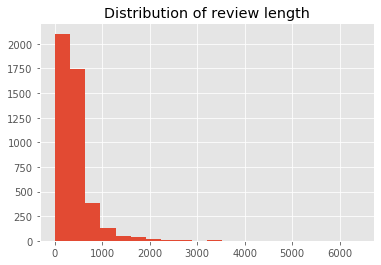

In [7]:
# And take a look at the distribution of the length
data['review_length'].hist(bins=20)
plt.title('Distribution of review length')

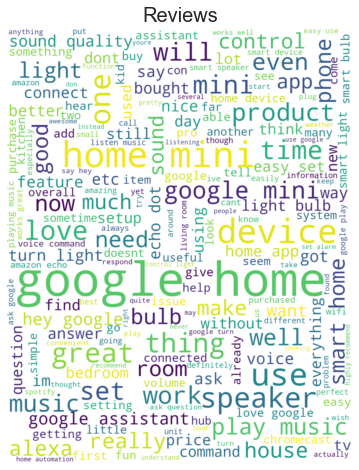

In [8]:
#words cloud of most comman words 
A = np.array(Image.open('../input/google_homemini.png'))
np.random.seed(321)
sns.set(rc={'figure.figsize':(8,8)})
reviews = ' '.join(data['verified_reviews'].tolist())

wordcloud = WordCloud(mask=A,background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Text(0.5, 1.0, 'Counts of each shops')

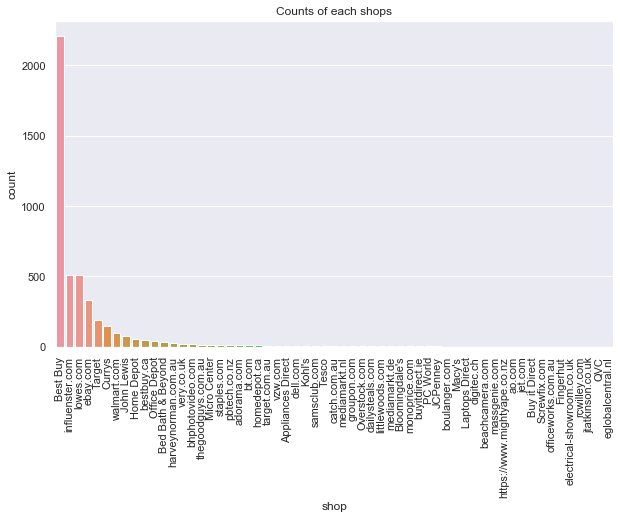

In [9]:
#reviews on shops 
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data.shop,
              order = data['shop'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Counts of each shops')

Best Buy               2209
influenster.com         513
lowes.com               512
ebay.com                334
Target                  193
Currys                  146
walmart.com              99
John Lewis               74
Home Depot               56
bestbuy.ca               46
Office Depot             42
Bed Bath & Beyond        33
harveynorman.com.au      26
very.co.uk               18
bhphotovideo.com         16
Name: shop, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4317 entries, 0 to 4499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            4317 non-null   float64
 1   date              4317 non-null   object 
 2   shop              4317 non-null   object 
 3   title             4317 non-null   object 
 4   verified_reviews  4317 non-null   object 
 5   review_length     4317 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 236.1+ KB


Text(0.5, 1.0, 'Counts of each shops')

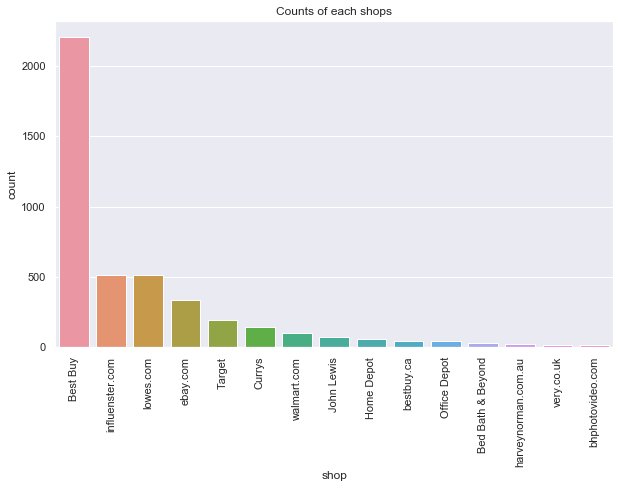

In [10]:
#reviews on top 15 shops 
top15 = data['shop'].value_counts().nlargest(15)
print(top15)
data = data[data['shop'].isin(top15.index)]
data.info()
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data.shop,
              order = data['shop'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Counts of each shops')

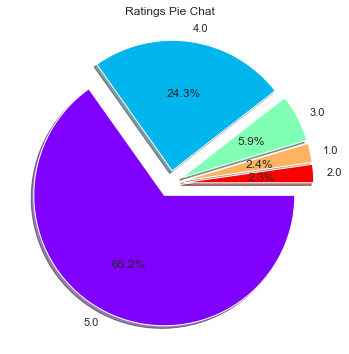

In [11]:
import matplotlib.cm as cm

#count data rating
counts = data.rating.value_counts()
#rating pie
values = counts.values
labels = counts.index
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.pie(values, 
        colors=colors, 
        labels=labels,
        explode=explode, 
        autopct='%1.1f%%',
        counterclock=False,
        shadow=True)
plt.title('Ratings Pie Chat')
plt.show()

In [30]:
data5 = data[data.rating == 5]
data_not_5 = data[data.rating != 5]
data1 = data[data.rating == 1]
data_12 = data[data.rating <= 2]
data_122 = data[data.rating <= 3]
data_345 = data[data.rating >= 3]
data_45 = data[data.rating >= 4]

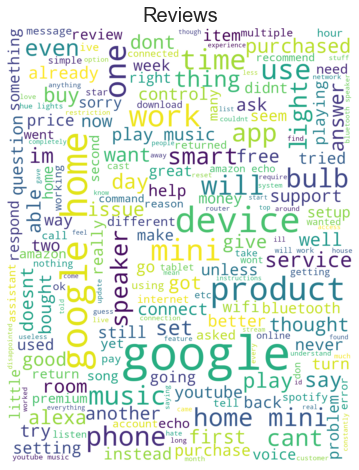

In [13]:
#words cloud of most comman words for rating 1
A = np.array(Image.open('../input/google_homemini.png'))
np.random.seed(321)
sns.set(rc={'figure.figsize':(8,8)})
reviews = ' '.join(data1['verified_reviews'].tolist())

wordcloud = WordCloud(mask=A,background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

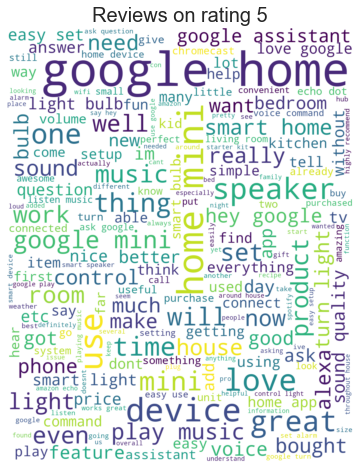

In [14]:
#words cloud of most comman words for rating 5
A = np.array(Image.open('../input/google_homemini.png'))
np.random.seed(321)
sns.set(rc={'figure.figsize':(8,8)})
reviews = ' '.join(data5['verified_reviews'].tolist())

wordcloud = WordCloud(mask=A,background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews on rating 5',size=20)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

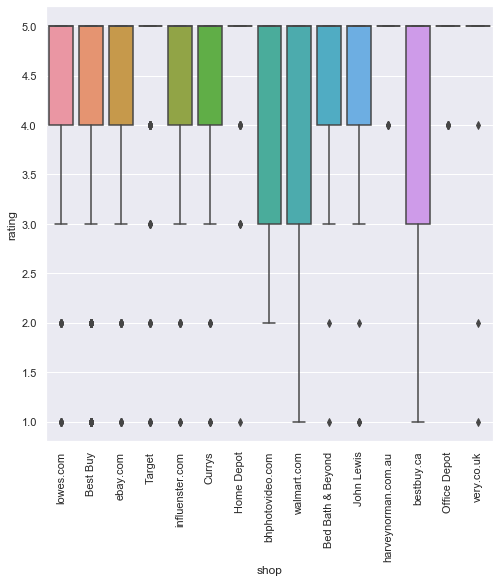

In [15]:
#relationship between rating and shop
sns.boxplot(data.shop, data.rating)
plt.xticks(rotation = 90)

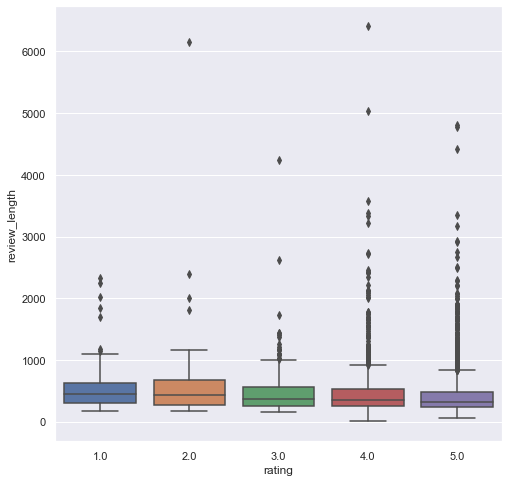

In [16]:
#relationship between rating and reviews lenth
sns.boxplot('rating','review_length',data=data)


In [17]:
data['log_review_length'] = data.review_length.apply(lambda x: (np.log(x)+1))


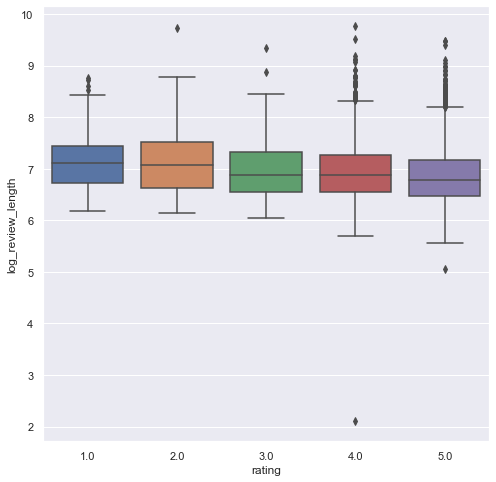

In [18]:
sns.boxplot('rating','log_review_length',data=data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

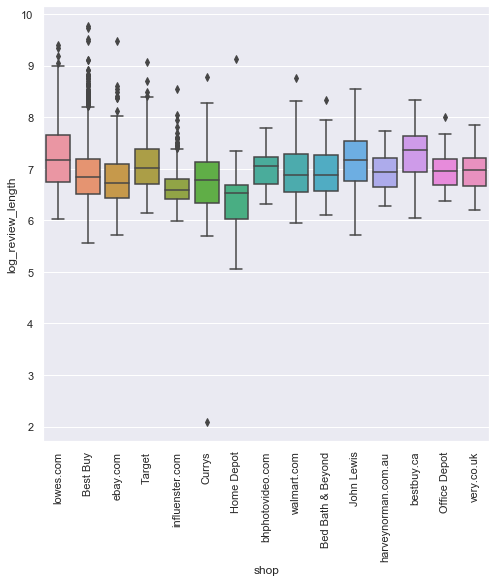

In [19]:
sns.boxplot('shop','log_review_length',data=data)
plt.xticks(rotation = 90)

In [21]:
#preprocessing 
from collections import Counter

text = ' '.join(data['verified_reviews'].tolist())
review_word = text.split(' ')
all_reviews = ' '.join(review_word)
words = all_reviews.split()

# words wrong datatype
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

reviews_ints = []
for review in review_word:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [22]:
print('Unique words: ', len((vocab_to_int)))


Unique words:  10170


In [23]:
counts.most_common(20)


[('the', 17175),
 ('to', 13263),
 ('and', 10832),
 ('i', 10695),
 ('it', 9920),
 ('a', 8235),
 ('google', 6543),
 ('is', 6096),
 ('for', 5289),
 ('my', 4980),
 ('home', 4789),
 ('you', 4092),
 ('of', 4022),
 ('in', 3998),
 ('with', 3819),
 ('this', 3765),
 ('have', 3561),
 ('on', 3099),
 ('that', 3043),
 ('mini', 2879)]

In [29]:
data_1_2['rating'].value_counts()


1.0    102
2.0     98
Name: rating, dtype: int64

In [39]:
def common_words(data, tops):
    text1 = ' '.join(data.tolist())
    review_word1 = text1.split(' ')
    all_reviews1 = ' '.join(review_word1)
    words1 = all_reviews1.split()

    # words wrong datatype
    counts1 = Counter(words1)
    vocab1 = sorted(counts1, key=counts1.get, reverse=True)
    vocab_to_int1 = {word: ii for ii, word in enumerate(vocab1, 1)}

    reviews_ints1 = []
    for review in review_word1:
        reviews_ints1.append([vocab_to_int1[word] for word in review.split()])
    return counts1.most_common(tops)

In [40]:
# 20 common words on rating 1
common_words(data1['verified_reviews'], 20)


[('the', 463),
 ('to', 406),
 ('i', 365),
 ('it', 311),
 ('and', 263),
 ('a', 244),
 ('google', 207),
 ('my', 141),
 ('with', 131),
 ('this', 131),
 ('you', 123),
 ('is', 121),
 ('not', 116),
 ('for', 114),
 ('of', 114),
 ('in', 112),
 ('home', 109),
 ('that', 103),
 ('on', 99),
 ('have', 91)]

In [35]:
data['positive'] = 0
data.loc[data['rating'] ==5, 'positive'] = 1

y = data['positive']

In [55]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

data['cleaned_reviews'] = data.verified_reviews.apply(lambda x: x.lower())
data['cleaned_reviews'] = data.cleaned_reviews.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
data['cleaned_reviews'] = data.cleaned_reviews.apply(lambda x: word_tokenize(x))

data['cleaned_reviews'] = data.cleaned_reviews.apply(lambda x: [w for w in x if w not in stop_words])

data['cleaned_reviews'] = data.cleaned_reviews.apply(lambda x: ' '.join(x))

In [56]:
data.head()


,rating,date,shop,title,verified_reviews,review_length,log_review_length,positive,cleaned_reviews
0,5.0,3 months ago,lowes.com,"Great way to get started with a ""smart home""",not only has this been fun to use its making m...,2672,8.890583,1,fun use making life whole lot simpler heres sc...
1,5.0,3 months ago,lowes.com,Functional small speaker with big sound,the “smart light starter kit” consists of 2 pr...,4423,9.394573,1,“ smart light starter kit ” consists 2 product...
2,5.0,8 months ago,Best Buy,Solid Combo Makes a Good Smart Home Starting P...,if youre invested in the google ecosystem and ...,2487,8.818832,1,youre invested google ecosystem starting smart...
3,1.0,2 months ago,lowes.com,I don't know what went wrong??? Bulb doesn't work,i bought the kit on black friday 2019 for 20 b...,2248,8.717796,0,bought kit black friday 2019 20 couldnt pass g...
4,4.0,4 months ago,lowes.com,Nice if you don't mind privacy issues,first off lets be clear the kit includes a sma...,2413,8.788626,0,first lets clear kit includes smart bulb googl...


In [57]:
data5 = data[data.rating == 5]
data_not_5 = data[data.rating != 5]
data1 = data[data.rating == 1]
data_12 = data[data.rating <= 2]
data_122 = data[data.rating <= 3]
data_345 = data[data.rating >= 3]
data_45 = data[data.rating >= 4]

In [58]:
# 20 common words on rating 1
common_words(data1['cleaned_reviews'], 20)

[('google', 207),
 ('home', 109),
 ('mini', 70),
 ('music', 59),
 ('would', 56),
 ('’', 54),
 ('one', 47),
 ('product', 46),
 ('work', 42),
 ('device', 40),
 ('get', 39),
 ('use', 39),
 ('play', 37),
 ('phone', 36),
 ('like', 32),
 ('app', 31),
 ('time', 31),
 ('smart', 28),
 ('could', 28),
 ('cant', 28)]

In [59]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4317 entries, 0 to 4499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             4317 non-null   float64
 1   date               4317 non-null   object 
 2   shop               4317 non-null   object 
 3   title              4317 non-null   object 
 4   verified_reviews   4317 non-null   object 
 5   review_length      4317 non-null   int64  
 6   log_review_length  4317 non-null   float64
 7   positive           4317 non-null   int64  
 8   cleaned_reviews    4317 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 497.3+ KB


In [60]:
#Model
#Step 1.1
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train, X_test, y_train, y_test = train_test_split(data["cleaned_reviews"], y, test_size=0.33
                                    ,random_state=53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english")

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

y_train = np.asarray(y_train.values)

#top 300 features
ch2 = SelectKBest(chi2, k = 300)

X_new = ch2.fit_transform(count_train, y_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

X_test_new = ch2.transform(X=count_test)

In [79]:
print(X_new.shape)

(2892, 300)


In [61]:
#Step 1.2
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [62]:
#Step 2
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

0100  05  10  100  1000  10000  100x  1010  1020  10am  ...  yrs  yup  \
0     0   0   0    0     0      0     0     0     0     0  ...    0    0   
1     0   0   0    0     0      0     0     0     0     0  ...    0    0   
2     0   0   0    0     0      0     0     0     0     0  ...    0    0   
3     0   0   0    0     0      0     0     0     0     0  ...    0    0   
4     0   0   0    0     1      0     0     0     0     0  ...    0    0   

   zero  zigbee  zillion  zip  zone  zones  zwave  œthanksâ  
0     0       0        0    0     0      0      0         0  
1     0       0        0    0     0      0      0         0  
2     0       0        0    0     0      0      0         0  
3     0       0        0    0     0      0      0         0  
4     0       0        0    0     0      0      0         0  

[5 rows x 7741 columns]
   0100   05   10  100      1000  10000  100x  1010  1020  10am  ...  yrs  \
0   0.0  0.0  0.0  0.0  0.000000    0.0   0.0   0.0   0.0   0.0  ...  0.

In [63]:
def nb_model(X_train, X_test, y_train, y_test):
    # Create a Multinomial Naive Bayes classifier: nb_classifier
    nb_classifier = MultinomialNB()
    # Fit the classifier to the training data
    nb_classifier.fit(X_train, y_train)
    # Create the predicted tags: pred
    pred = nb_classifier.predict(X_test)
    # Calculate the accuracy score: score
    score = metrics.accuracy_score(y_test, pred)
    print('Accuracy is:', score)
    f1 = metrics.f1_score(y_test, pred)
    print('F score is:', f1)
    sns.heatmap(metrics.confusion_matrix(pred, y_test), annot=True, fmt='2.0f')
    plt.show()

Accuracy is: 0.7452631578947368
F score is: 0.8094488188976379


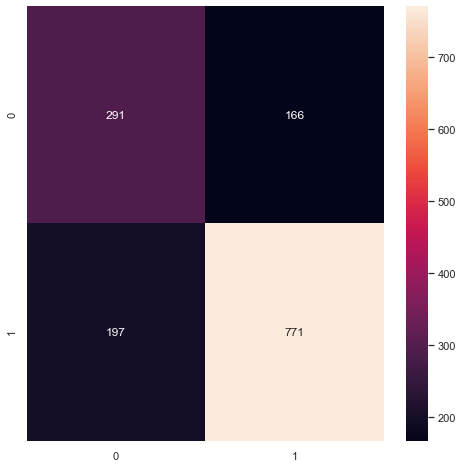

In [64]:
#Step 3
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_model(X_new, X_test_new, y_train, y_test)

In [80]:
print(tfidf_train.shape)

(2892, 7741)


Accuracy is: 0.6807017543859649
F score is: 0.8037947391116861


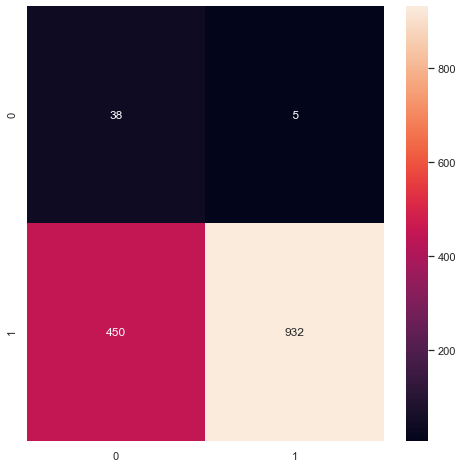

In [65]:
#Step 4
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_model(tfidf_train, tfidf_test, y_train, y_test)

In [67]:
def rf_model(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(random_state=51)
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    # Create the predicted tags: pred
    pred = clf.predict(X_test)
    # Calculate the accuracy score: score
    score = metrics.accuracy_score(y_test, pred)
    print('Accuracy is:', score)
    f1 = metrics.f1_score(y_test, pred)
    print('F score is:', f1)
    sns.heatmap(metrics.confusion_matrix(pred, y_test), annot=True, fmt='2.0f')
    plt.show()

In [71]:
from sklearn.feature_extraction.text import TfidfTransformer
def text_preprocessing(train,train_y,test):
    
    CountVectorizer(stop_words="english")
    count = count_vectorizer.fit_transform(train)
    count_test = count_vectorizer.transform(X_test)
    
    tfidf_vectorizer = TfidfTransformer()
    tfidf = tfidf_vectorizer.fit_transform(count)
    tfidf_test = tfidf_vectorizer.transform(count_test)
    #top 300 features
    ch2 = SelectKBest(chi2, k = 300)
    
    train_new = ch2.fit_transform(tfidf, y_train)
    test_new = ch2.transform(tfidf_test)
    
    return train_new, test_new

In [78]:
train, test = text_preprocessing(X_train, y_train, X_test)
print(train.shape)


(2892,)
(2892, 300)


Accuracy is: 0.7298245614035088
F score is: 0.8089330024813897


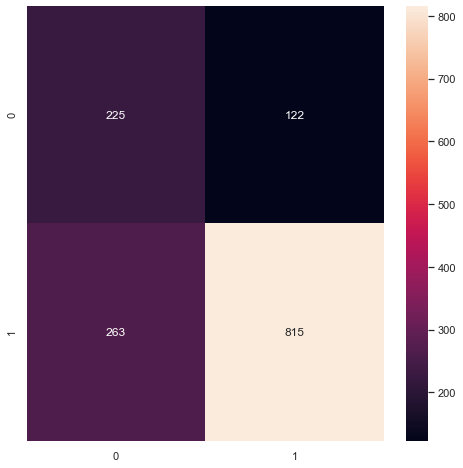

In [75]:
#Step 5
#random forest classifier
rf_model(train, test, y_train, y_test)

Accuracy is: 0.720701754385965
F score is: 0.8021868787276343


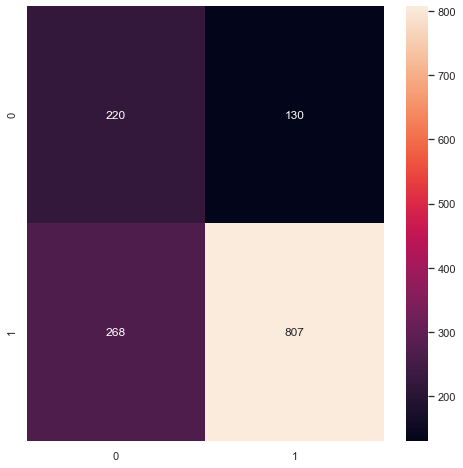

In [76]:
#Step 6
rf_model(X_new, X_test_new, y_train, y_test)

Accuracy is: 0.7263157894736842
F score is: 0.8189415041782729


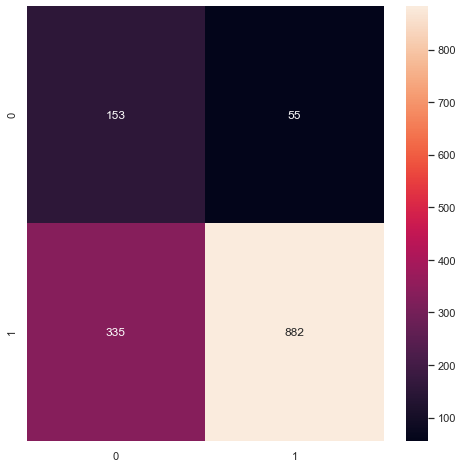

In [77]:
#Step 7
rf_model(tfidf_train, tfidf_test, y_train, y_test)

In [81]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

scorer = metrics.make_scorer(metrics.fbeta_score, beta=0.5)

parameters = {
    'n_estimators': [150, 180, 250], 
    'max_features': [120,150], 
    'max_depth': [120,135,150],
    'min_samples_split':[3,5],
    'min_samples_leaf':[1,3,5]
    }

grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_new, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test_new)

score = metrics.accuracy_score(y_test, best_predictions)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, best_predictions)
print('F score is:',f1)
sns.heatmap(metrics.confusion_matrix(best_predictions, y_test),annot=True,fmt='2.0f')
plt.show()